In [1]:
# Cell 1 – Import & hàm hiển thị
import cv2 # dùng OpenCV cho xử lý ảnh (đọc ảnh, SIFT, warp, v.v.)
import numpy as np # xử lý ma trận, tính toán số
import matplotlib.pyplot as plt # dùng để hiển thị ảnh trong Jupyter

# Đặt kích thước mặc định cho figure của matplotlib
plt.rcParams['figure.figsize'] = (8, 5)

def show_img(img_bgr, title=""):
    """
    Hiển thị ảnh BGR bằng matplotlib.
    - OpenCV đọc ảnh theo thứ tự kênh BGR
    - matplotlib hiển thị theo thứ tự kênh RGB
    => Cần đổi BGR -> RGB trước khi vẽ
    """
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)  # Đổi không gian màu BGR -> RGB
    plt.figure()
    plt.imshow(img_rgb)                                # Hiển thị ảnh màu
    plt.title(title)                                   # Tiêu đề
    plt.axis("off")                                    # Tắt trục toạ độ cho đẹp
    plt.show()



Kích thước ảnh trái : (1360, 2048, 3)
Kích thước ảnh giữa: (1360, 2048, 3)
Kích thước ảnh phải: (1360, 2048, 3)


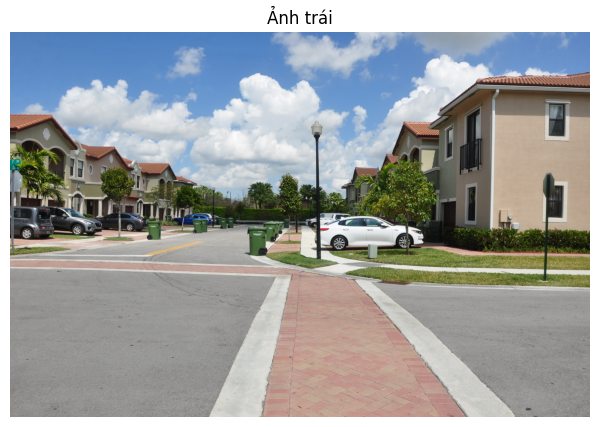

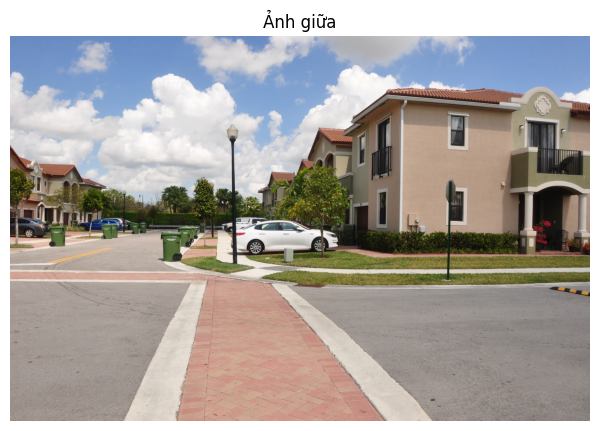

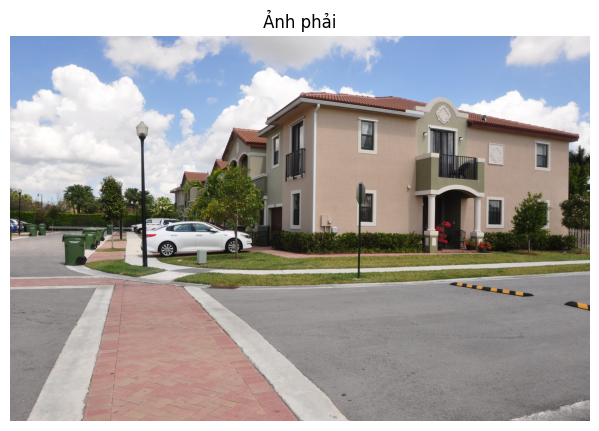

In [2]:
# Cell 2 – Đường dẫn & đọc 3 ảnh 

# Đường dẫn thư mục chứa 3 ảnh (bộ ảnh thí nghiệm)
image_dir = r"C:\Users\Public\panorama_sift_three_pictures\pictures"

# Đọc 3 ảnh: trái, giữa, phải (định dạng BGR)
left_img   = cv2.imread(fr"{image_dir}\img_left.jpg")
middle_img = cv2.imread(fr"{image_dir}\img_middle.jpg")  
right_img  = cv2.imread(fr"{image_dir}\img_right.jpg")

# In kích thước (h, w, c) của từng ảnh để kiểm tra
print("Kích thước ảnh trái :", left_img.shape)
print("Kích thước ảnh giữa:", middle_img.shape)
print("Kích thước ảnh phải:", right_img.shape)

# Hiển thị 3 ảnh gốc
show_img(left_img,   "Ảnh trái")
show_img(middle_img, "Ảnh giữa")
show_img(right_img,  "Ảnh phải")


In [3]:
# Cell 3 – SIFT + matching giữa 2 ảnh 

def sift_feature(image_bgr):
    """
    Tính keypoint & descriptor SIFT cho 1 ảnh BGR.
    - Bước 1: chuyển sang ảnh xám (SIFT làm việc trên grayscale)
    - Bước 2: tạo đối tượng SIFT
    - Bước 3: detect (tìm keypoint) và compute (tính descriptor)
    """
    gray = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2GRAY)  # BGR -> Gray
    sift = cv2.SIFT_create()                            # Khởi tạo SIFT
    kp, des = sift.detectAndCompute(gray, None)         # kp: list keypoints, des: ma trận descriptor
    # Keypoints là các điểm đặc trưng như góc và đỉnh
    # descriptors là vectơ mô tả cục bộ quanh mỗi keypoint
    return kp, des
    
#Hàm match sift giữa 2 ảnh
def match_sift(kp1, des1, kp2, des2,
               ratio_thresh=0.75,
               debug_title=None,
               img1=None, img2=None):
    """
    KNN matching + Lowe ratio test.
    Trả về:
      - good_matches: danh sách match tốt (lọc theo tỉ lệ khoảng cách)
      - H: homography (ảnh 2 -> ảnh 1) nếu tính được

    kp1, des1: keypoint & descriptor của ảnh 1 (reference)
    kp2, des2: keypoint & descriptor của ảnh 2 (ảnh cần warp)
    """
    # Brute Force Matcher dùng khoảng cách L2 - Kcach Euclid (chuẩn cho SIFT), không bật crossCheck
    bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=False)

    # KNN matching: với mỗi descriptor của ảnh 1 -> lấy 2 match gần nhất ở ảnh 2
    knn_matches = bf.knnMatch(des1, des2, k=2)

    good = []
    for m, n in knn_matches:
        # Áp dụng Lowe's ratio test:
        # Nếu khoảng cách m nhỏ hơn ratio_thresh * n -> m là match đáng tin
        if m.distance < ratio_thresh * n.distance:
            good.append(m)

    print(f"[{debug_title}] Số match tốt: {len(good)}")

    H = None
    """
    Homography là “cầu nối toán học” dùng các điểm tương ứng đó để căn chỉnh 2 (hoặc 3) ảnh lên cùng một hệ tọa độ → mới ghép được panorama.
    Là key để warp 2 ảnh trái, phải về cùng hệ tọa độ với ảnh giữa
    """
    # Để tính homography cần ít nhất 4 cặp điểm
    if len(good) >= 4:
        # Lấy toạ độ điểm ở ảnh 1 (reference)
        pts1 = np.float32([kp1[m.queryIdx].pt for m in good]).reshape(-1, 1, 2)
        # Lấy toạ độ điểm tương ứng ở ảnh 2 (moving)
        pts2 = np.float32([kp2[m.trainIdx].pt for m in good]).reshape(-1, 1, 2)

        # Tính homography: pts2 -> pts1, dùng RANSAC để loại bỏ outlier
        H, mask = cv2.findHomography(pts2, pts1, cv2.RANSAC)
        print(f"[{debug_title}] Homography:\n", H)
    else:
        print(f"[{debug_title}] Không đủ match để tính homography!")

    # Hàm vẽ các match tốt
    if debug_title is not None and img1 is not None and img2 is not None and len(good) > 0:
        draw_n = min(1000, len(good))   # Giới hạn số match vẽ (tránh quá nhiều)
        matches_draw = good[:draw_n]
        match_img = cv2.drawMatches( # ghép 2 ảnh cạnh nhau, nối cặp điểm match bằng đường thẳng
            img1, kp1,   # Ảnh 1 + keypoints
            img2, kp2,   # Ảnh 2 + keypoints
            matches_draw,
            None,
            flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
        )
        show_img(match_img, f"Match SIFT - {debug_title} (top {draw_n})")

    return good, H

# Mục đích Cell 3: chuẩn bị hàm phát hiện đặc trưng và so khớp giữa hai ảnh, đồng thời ước lượng homography.


SIFT keypoints:
  Trái : 7722
  Giữa: 7188
  Phải: 6970
[LEFT <-> MIDDLE] Số match tốt: 3098
[LEFT <-> MIDDLE] Homography:
 [[ 1.22889589e+00 -1.70045223e-03 -4.47891693e+02]
 [ 6.99157979e-02  1.12559985e+00 -7.83179049e+01]
 [ 1.13870897e-04 -5.78437748e-06  1.00000000e+00]]


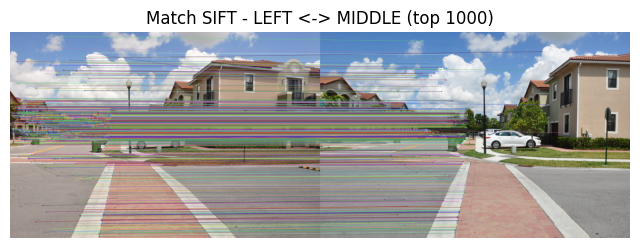

[RIGHT <-> MIDDLE] Số match tốt: 2831
[RIGHT <-> MIDDLE] Homography:
 [[ 8.09960038e-01  3.16010194e-03  3.71060946e+02]
 [-5.93898167e-02  9.18919060e-01  4.89257310e+01]
 [-9.28165290e-05  2.07406902e-07  1.00000000e+00]]


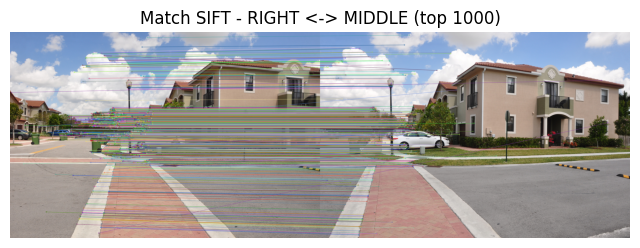

In [4]:
# Cell 4 – Tính SIFT cho 3 ảnh & homography

# Tính SIFT cho từng ảnh (trái, giữa, phải)
kp_left,   des_left   = sift_feature(left_img)
kp_mid,    des_mid    = sift_feature(middle_img)
kp_right,  des_right  = sift_feature(right_img)

# In ra số lượng keypoint của từng ảnh để xem ảnh nào “nhiều đặc trưng” hơn.
print("SIFT keypoints:")
print("  Trái :", len(kp_left))
print("  Giữa:", len(kp_mid))
print("  Phải:", len(kp_right))

# Match: TRÁI <-> GIỮA
#  - Ảnh 1: middle_img (reference)
#  - Ảnh 2: left_img   (moving)
# => Tính homography: left -> middle (H_left_to_mid)
good_lm, H_left_to_mid = match_sift(
    kp_mid, des_mid,         # kp1, des1 (ảnh giữa)
    kp_left, des_left,       # kp2, des2 (ảnh trái)
    ratio_thresh=0.75,
    debug_title="LEFT <-> MIDDLE",
    img1=middle_img, img2=left_img
)

# Match: PHẢI <-> GIỮA
#  - Ảnh 1: middle_img (reference)
#  - Ảnh 2: right_img  (moving)
# => Tính homography: right -> middle (H_right_to_mid)
good_rm, H_right_to_mid = match_sift(
    kp_mid, des_mid,
    kp_right, des_right,
    ratio_thresh=0.75,
    debug_title="RIGHT <-> MIDDLE",
    img1=middle_img, img2=right_img
)

# => Mục đích Cell 4: tính đặc trưng cho 3 ảnh và tìm 2 homography:

In [5]:
# Cell 5 – Hàm tính canvas chung + feather blending + auto crop
def compute_global_canvas(left_img, middle_img, right_img, H_left_to_mid, H_right_to_mid):
    """
    Tính kích thước canvas chung & ma trận offset_matrix cho cả 3 ảnh.
    Ý tưởng:
    - Lấy 4 góc mỗi ảnh (0,0), (w,0), (0,h), (w,h)
    - Warp góc ảnh trái & phải sang hệ toạ độ ảnh giữa (dùng homography)
    - Gộp tất cả điểm -> tìm min/max x,y -> ra khung bao ngoài cùng (bounding box)
    - Từ đó suy ra chiều rộng/chiều cao canvas và ma trận dịch (offset)
    """
    hL, wL = left_img.shape[:2]
    hM, wM = middle_img.shape[:2]
    hR, wR = right_img.shape[:2]

    # Lấy 4 góc của 3 ảnh (trong hệ toạ độ riêng của từng ảnh)
    corners_left  = np.float32([[0,0], [wL,0], [0,hL], [wL,hL]]).reshape(-1,1,2)
    corners_mid   = np.float32([[0,0], [wM,0], [0,hM], [wM,hM]]).reshape(-1,1,2)
    corners_right = np.float32([[0,0], [wR,0], [0,hR], [wR,hR]]).reshape(-1,1,2)
    # lấy 4 góc của mỗi ảnh trong hệ tọa độ riêng (0,0), (w,0), (0,h), (w,h)
    # Warp góc ảnh trái & phải sang hệ toạ độ ảnh giữa:
    
    # vị trí bốn góc ảnh trái sau khi đưa về hệ tọa độ ảnh giữa
    corners_left_warp  = cv2.perspectiveTransform(corners_left,  H_left_to_mid) 
    # vị trí bốn góc ảnh phải sau khi đưa về hệ tọa độ ảnh giữa
    corners_right_warp = cv2.perspectiveTransform(corners_right, H_right_to_mid) 
    corners_mid_warp   = corners_mid  # Ảnh giữa là gốc nên không cần warp

    # Gộp toàn bộ góc lại để tính bounding box - khung của ảnh panorama
    all_corners = np.concatenate(
        (corners_left_warp, corners_mid_warp, corners_right_warp),
        axis=0
    )
    # Tìm min/max theo trục x,y
    [x_min, y_min] = all_corners.min(axis=0).ravel()
    [x_max, y_max] = all_corners.max(axis=0).ravel()

    # Làm tròn xuống & làm tròn lên để an toàn
    x_min, y_min = int(np.floor(x_min)), int(np.floor(y_min))
    x_max, y_max = int(np.ceil(x_max)), int(np.ceil(y_max))

    # Kích thước canvas (chiều rộng, chiều cao)
    canvas_w = x_max - x_min
    canvas_h = y_max - y_min

    # Ma trận offset:
    # Dịch toàn bộ điểm sao cho (x_min, y_min) -> (0,0)
    offset_matrix = np.array([
        [1, 0, -x_min],  # Dịch theo X
        [0, 1, -y_min],  # Dịch theo Y
        [0, 0, 1]
    ], dtype=float)

    print("Canvas size:", canvas_w, "x", canvas_h)
    return canvas_w, canvas_h, offset_matrix


def feather_blend_two(imgA, imgB):
    """
    Feather blending 2 ảnh cùng kích thước.
    - Pixel = 0 (đen cả 3 kênh) được coi là nền (no data).
    - Vùng chồng lắp (overlap) sẽ được blend theo trọng số tuyến tính theo toạ độ x.

    Trả về: ảnh đã blend.
    """
    assert imgA.shape == imgB.shape
    h, w = imgA.shape[:2]

    # mask: pixel nào có dữ liệu (ít nhất 1 kênh != 0)
    maskA = np.any(imgA != 0, axis=2)
    maskB = np.any(imgB != 0, axis=2)

    onlyA   =  maskA & ~maskB   # chỉ A
    onlyB   =  maskB & ~maskA   # chỉ B
    overlap =  maskA &  maskB   # chồng lắp

    result = np.zeros_like(imgA)

    # Vùng chỉ có A hoặc chỉ có B -> copy trực tiếp
    result[onlyA] = imgA[onlyA]
    result[onlyB] = imgB[onlyB]

    if np.any(overlap):
        # X: ma trận toạ độ cột (0..w-1) lặp theo hàng (h)
        X = np.tile(np.arange(w), (h, 1))

        # x0: cột nhỏ nhất trong vùng overlap; x1: cột lớn nhất
        x0 = X[overlap].min()
        x1 = X[overlap].max()
        if x1 == x0:
            # Trường hợp overlap rất nhỏ -> dùng trọng số 0.5 đều cho 2 ảnh
            wA = np.full((h, w), 0.5, dtype=np.float32)
        else:
            # Trọng số A giảm dần từ trái sang phải trong vùng chồng lắp
            wA = (x1 - X).astype(np.float32) / (x1 - x0)
        wB = 1.0 - wA  # Trọng số B bù lại

        # Chỉ áp dụng trọng số cho vùng overlap
        for c in range(3):  # 3 kênh màu BGR
            chanA = imgA[:,:,c].astype(np.float32)
            chanB = imgB[:,:,c].astype(np.float32)
            blend = chanA * wA + chanB * wB        # Blend theo trọng số
            tmp = result[:,:,c].astype(np.float32)
            tmp[overlap] = blend[overlap]          # Gán vào vùng overlap
            result[:,:,c] = np.clip(tmp, 0, 255).astype(np.uint8)

    return result # => Kết quả: vùng giao giữa 2 ảnh được “nhòe” dần, tránh đường nối gắt

def auto_crop_non_black(pano_bgr):
    """
    Tự động crop bỏ viền đen quanh ảnh panorama.
    Ý tưởng:
    - Đổi sang gray
    - Pixel > 0 coi là có dữ liệu
    - Tìm contour ngoài cùng (lớn nhất)
    - Cắt ảnh theo bounding box của contour đó
    """
    gray = cv2.cvtColor(pano_bgr, cv2.COLOR_BGR2GRAY)
    # Pixel > 0 -> 255 (trắng); pixel = 0 -> 0 (đen)
    _, thresh = cv2.threshold(gray, 1, 255, cv2.THRESH_BINARY)

    # Tìm các contour ngoài (các vùng có dữ liệu)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL,
                                   cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        # Không tìm thấy contour -> trả ảnh gốc
        return pano_bgr

    # Chọn contour có diện tích lớn nhất (vùng ảnh chính)
    largest = max(contours, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(largest)
    cropped = pano_bgr[y:y+h, x:x+w]
    return cropped

Canvas size: 2965 x 1555


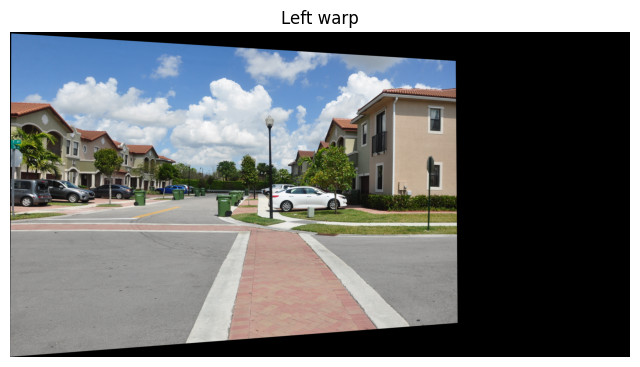

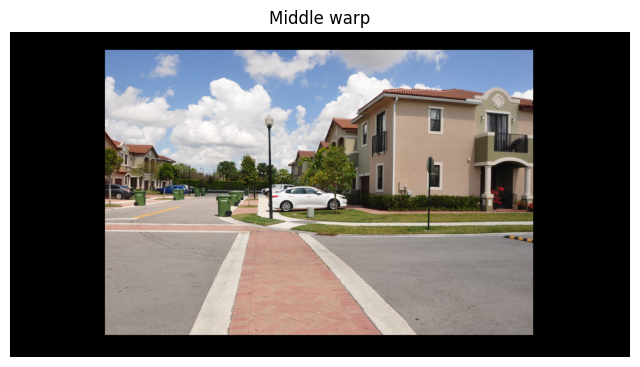

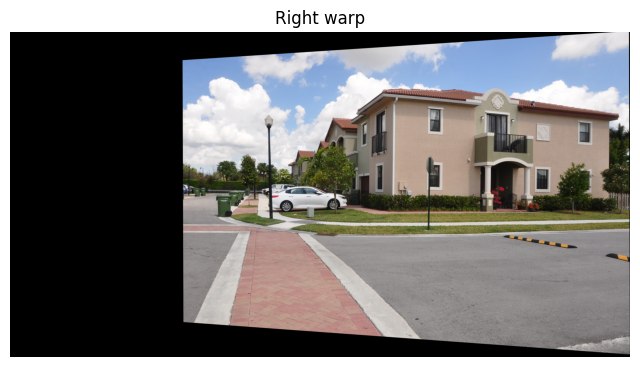

In [6]:
# Cell 6 – Warp 3 ảnh vào canvas chung
# Nếu không tính được homography cho 1 trong 2 cặp -> dừng
if H_left_to_mid is None or H_right_to_mid is None:
    raise RuntimeError("Không tính được homography cho một trong hai cặp ảnh!")

# Tính kích thước canvas chung và ma trận offset (dịch)
canvas_w, canvas_h, offset_matrix = compute_global_canvas(
    left_img, middle_img, right_img,
    H_left_to_mid, H_right_to_mid
)

# Warp từng ảnh sang canvas chung.
# Lưu ý: transform tổng = offset_matrix * H (nhân ma trận 3x3)
left_warp = cv2.warpPerspective(
    left_img, offset_matrix.dot(H_left_to_mid),
    (canvas_w, canvas_h)
)
mid_warp = cv2.warpPerspective(
    middle_img, offset_matrix,
    (canvas_w, canvas_h)
)
right_warp = cv2.warpPerspective(
    right_img, offset_matrix.dot(H_right_to_mid),
    (canvas_w, canvas_h)
)

# Xem thử 3 ảnh sau khi warp lên canvas
show_img(left_warp,  "Left warp")
show_img(mid_warp,   "Middle warp")
show_img(right_warp, "Right warp")

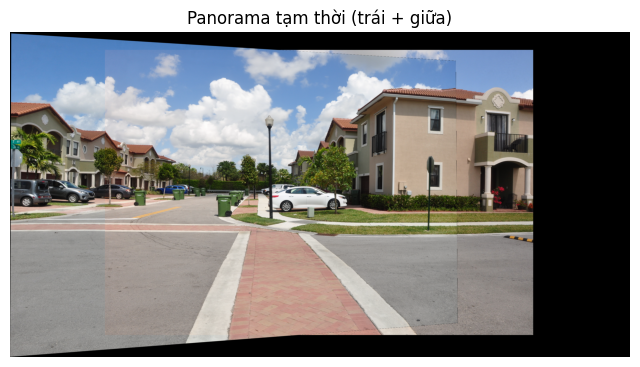

In [7]:
# Cell 7 – Panorama tạm thời TRÁI + GIỮA
# Blend ảnh giữa (mid_warp) với ảnh trái (left_warp)
pano_left_mid = feather_blend_two(mid_warp, left_warp)
show_img(pano_left_mid, "Panorama tạm thời (trái + giữa)")


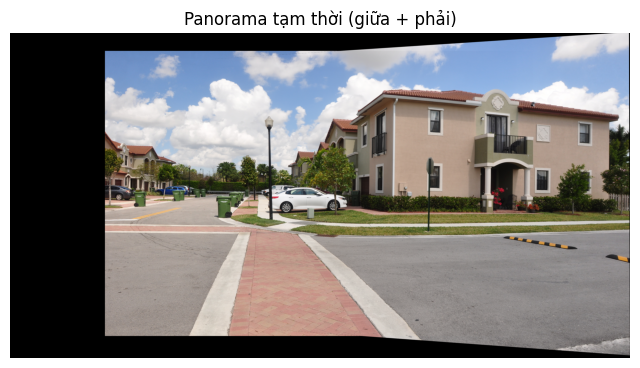

In [8]:
# Cell 8 – Panorama tạm thời GIỮA + PHẢI
# Blend ảnh giữa (mid_warp) với ảnh phải (right_warp)
pano_mid_right = feather_blend_two(mid_warp, right_warp)
show_img(pano_mid_right, "Panorama tạm thời (giữa + phải)")

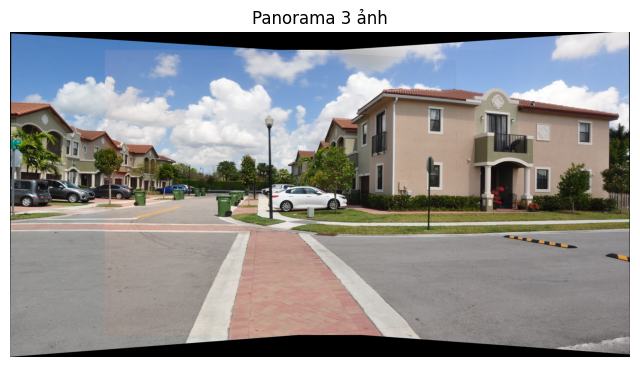

Đã lưu panorama (crop): C:\Users\Public\panorama_sift_three_pictures\pictures\panorama_result_cropped_city.jpg


In [9]:
# Cell 9 – Panorama 3 ảnh 


# Ghép 3 ảnh: (trái + giữa) rồi ghép thêm phải
pano_full = feather_blend_two(pano_left_mid, right_warp)

# Auto crop bỏ viền đen
pano_cropped = auto_crop_non_black(pano_full)
show_img(pano_cropped, "Panorama 3 ảnh")

# Lưu kết quả
save_crop  = fr"{image_dir}\panorama_result_cropped_city.jpg"

cv2.imwrite(save_crop, pano_cropped)

print("Đã lưu panorama (crop):", save_crop)



In [10]:
# Cell 10: Website thực hành ghép ảnh panaroma

# Phần dưới là "bản khác" của các hàm SIFT, MATCH, BLEND, CROP
# được viết lại cho rõ ràng, sau đó dùng trong 2 chế độ:
# - stitch_two_bgr : ghép 2 ảnh (trái + phải)
# - stitch_three_bgr: ghép 3 ảnh (trái + giữa + phải)
# và tích hợp vào giao diện Gradio

import gradio as gr  # <- bạn nhớ import gradio nếu chưa import ở trên

# ================== HÀM CHUNG: SIFT, MATCH, BLEND, CROP ==================

def sift_feature(image_bgr):
    """
    Tính keypoint & descriptor SIFT cho 1 ảnh BGR.
    (phiên bản dùng cho web, tương tự ở trên)
    """
    gray = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2GRAY)
    sift = cv2.SIFT_create()
    kp, des = sift.detectAndCompute(gray, None)
    return kp, des

def match_sift_homography(kp_ref, des_ref, kp_mov, des_mov, ratio_thresh=0.75):
    """
    Khớp SIFT giữa ảnh 'ref' (tham chiếu) và 'mov' (ảnh cần warp).
    Trả về:
        - good: danh sách match tốt
        - H   : homography từ mov -> ref
    """
    if des_ref is None or des_mov is None:
        return [], None

    bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=False)
    raw_matches = bf.knnMatch(des_ref, des_mov, k=2)

    good = []
    for m, n in raw_matches:
        if m.distance < ratio_thresh * n.distance:
            good.append(m)

    if len(good) < 4:
        # Không đủ match để tính homography
        return good, None

    pts_ref = np.float32([kp_ref[m.queryIdx].pt for m in good]).reshape(-1, 1, 2)
    pts_mov = np.float32([kp_mov[m.trainIdx].pt for m in good]).reshape(-1, 1, 2)

    # Tính homography: pts_mov -> pts_ref
    H, mask = cv2.findHomography(pts_mov, pts_ref, cv2.RANSAC, 4.0)
    return good, H

def feather_blend_two(imgA, imgB):
    """
    Feather blending 2 ảnh cùng kích thước, pixel = 0 coi là nền (ko dữ liệu).
    (phiên bản dùng cho web; logic tương tự ở trên)
    """
    assert imgA.shape == imgB.shape
    h, w = imgA.shape[:2]

    maskA = np.any(imgA != 0, axis=2)
    maskB = np.any(imgB != 0, axis=2)

    onlyA   =  maskA & ~maskB
    onlyB   =  maskB & ~maskA
    overlap =  maskA &  maskB

    result = np.zeros_like(imgA)
    result[onlyA] = imgA[onlyA]
    result[onlyB] = imgB[onlyB]

    if np.any(overlap):
        X = np.tile(np.arange(w), (h, 1))
        x0 = X[overlap].min()
        x1 = X[overlap].max()
        if x1 == x0:
            wA = np.full((h, w), 0.5, dtype=np.float32)
        else:
            wA = (x1 - X).astype(np.float32) / (x1 - x0)
        wB = 1.0 - wA

        for c in range(3):
            chanA = imgA[:, :, c].astype(np.float32)
            chanB = imgB[:, :, c].astype(np.float32)
            blend = chanA * wA + chanB * wB
            tmp = result[:, :, c].astype(np.float32)
            tmp[overlap] = blend[overlap]
            result[:, :, c] = np.clip(tmp, 0, 255).astype(np.uint8)

    return result

def auto_crop_non_black(pano_bgr):
    """
    Tự động crop bỏ viền đen ngoài cùng của panorama.
    (phiên bản dùng cho web; logic như trước)
    """
    gray = cv2.cvtColor(pano_bgr, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, 1, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL,
                                   cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        return pano_bgr
    largest = max(contours, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(largest)
    cropped = pano_bgr[y:y + h, x:x + w]
    return cropped

def crop_vertical_band(img, keep_ratio=0.9):
    """
    Cắt bớt phần trên & dưới, giữ phần giữa theo tỉ lệ keep_ratio.
    Giúp khung panorama trông gọn hơn (đỡ nhiều trời/đất).
    """
    h, w = img.shape[:2]
    band_h = int(h * keep_ratio)   # chiều cao vùng giữ lại
    top = (h - band_h) // 2        # vị trí bắt đầu (theo chiều dọc)
    bottom = top + band_h
    return img[top:bottom, :]


# ================== GHÉP 2 ẢNH: TRÁI + PHẢI ==================

def stitch_two_bgr(left_img, right_img,
                   ratio_thresh=0.75,
                   min_matches=10):
    """
    Ghép img_right vào bên phải img_left bằng SIFT.
    - Tính SIFT
    - Match + tính homography (right -> left)
    - Warp ảnh phải sang khung của ảnh trái
    - Blend và crop viền đen
    """
    kp_left, des_left = sift_feature(left_img)
    kp_right, des_right = sift_feature(right_img)

    print(f"[2-ẢNH] keypoints trái={len(kp_left)}, phải={len(kp_right)}")

    # Match: right -> left
    good, H_right_to_left = match_sift_homography(
        kp_left, des_left,     # ref: ảnh trái
        kp_right, des_right,   # mov: ảnh phải
        ratio_thresh=ratio_thresh
    )
    print(f"[2-ẢNH] match tốt = {len(good)}")

    if H_right_to_left is None or len(good) < min_matches:
        raise ValueError(f"Không đủ match tốt cho chế độ 2 ảnh (={len(good)}).")

    h1, w1 = left_img.shape[:2]
    h2, w2 = right_img.shape[:2]

    # Canvas đơn giản: ghép ngang cạnh nhau (w1 + w2, max(h1,h2))
    pano_w = w1 + w2
    pano_h = max(h1, h2)

    # Warp ảnh phải sang canvas (dựa trên homography)
    warped_right = cv2.warpPerspective(right_img, H_right_to_left, (pano_w, pano_h))

    # Canvas cho ảnh trái & ảnh phải
    canvas_left  = np.zeros_like(warped_right)
    canvas_right = warped_right.copy()
    canvas_left[0:h1, 0:w1] = left_img  # đặt ảnh trái ở góc trên trái

    # Tạo mask để biết vùng nào có dữ liệu
    mask_left  = (canvas_left.sum(axis=2)  > 0)
    mask_right = (canvas_right.sum(axis=2) > 0)

    panorama = np.zeros_like(warped_right)
    only_l  = mask_left & ~mask_right
    only_r  = ~mask_left & mask_right
    overlap = mask_left & mask_right

    # Vùng chỉ có 1 trong 2 ảnh -> lấy trực tiếp
    panorama[only_l] = canvas_left[only_l]
    panorama[only_r] = canvas_right[only_r]

    # Vùng chồng lắp -> trung bình 0.5
    if np.any(overlap):
        left_overlap  = canvas_left[overlap].astype(np.float32)
        right_overlap = canvas_right[overlap].astype(np.float32)
        blended = 0.5 * left_overlap + 0.5 * right_overlap
        panorama[overlap] = blended.astype(np.uint8)

    # Cắt phần đen dư bên phải (cột không có pixel nào >0)
    gray_pan = cv2.cvtColor(panorama, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray_pan, 1, 255, cv2.THRESH_BINARY)
    cols = np.where(np.max(thresh, axis=0) > 0)[0]
    if len(cols) > 0:
        max_col = cols[-1]
        panorama = panorama[:, :max_col + 1]

    # Auto crop viền đen còn lại
    panorama = auto_crop_non_black(panorama)
    return panorama


# ================== GHÉP 3 ẢNH: TRÁI + GIỮA + PHẢI ==================

def compute_global_canvas_3(left_img, middle_img, right_img,
                            H_left_to_mid, H_right_to_mid,
                            delta_y=0):
    """
    Tính canvas chung & offset_matrix cho 3 ảnh (phiên bản cho web).
    delta_y: nếu muốn dịch ảnh lên/xuống thêm, có thể chỉnh tham số này.
    """
    hL, wL = left_img.shape[:2]
    hM, wM = middle_img.shape[:2]
    hR, wR = right_img.shape[:2]

    corners_left  = np.float32([[0,0], [wL,0], [0,hL], [wL,hL]]).reshape(-1,1,2)
    corners_mid   = np.float32([[0,0], [wM,0], [0,hM], [wM,hM]]).reshape(-1,1,2)
    corners_right = np.float32([[0,0], [wR,0], [0,hR], [wR,hR]]).reshape(-1,1,2)

    corners_left_warp  = cv2.perspectiveTransform(corners_left,  H_left_to_mid)
    corners_right_warp = cv2.perspectiveTransform(corners_right, H_right_to_mid)
    corners_mid_warp   = corners_mid

    all_corners = np.concatenate(
        (corners_left_warp, corners_mid_warp, corners_right_warp),
        axis=0
    )

    [x_min, y_min] = all_corners.min(axis=0).ravel()
    [x_max, y_max] = all_corners.max(axis=0).ravel()

    x_min, y_min = int(np.floor(x_min)), int(np.floor(y_min))
    x_max, y_max = int(np.ceil(x_max)), int(np.ceil(y_max))

    canvas_w = x_max - x_min
    canvas_h = (y_max - y_min) + delta_y   # cho phép tăng/giảm chiều cao

    offset_matrix = np.array([
        [1, 0, -x_min],           # dịch theo X
        [0, 1, -y_min + delta_y], # dịch theo Y + delta_y
        [0, 0, 1]
    ], dtype=float)

    return canvas_w, canvas_h, offset_matrix

def stitch_three_bgr(left_img, middle_img, right_img,
                     ratio_thresh=0.75,
                     min_matches=10,
                     keep_ratio=0.9):
    """
    Pipeline ghép 3 ảnh: trái + giữa + phải bằng SIFT.
    Các bước:
    - Tính SIFT 3 ảnh
    - Match trái-giữa & phải-giữa, tính H_left_to_mid và H_right_to_mid
    - Tính canvas chung, warp 3 ảnh
    - Blend (mid+left) rồi blend với right
    - Auto crop viền đen + crop trên/dưới giữ phần giữa
    """
    # 1) Tính SIFT cho 3 ảnh
    kp_left, des_left   = sift_feature(left_img)
    kp_mid,  des_mid    = sift_feature(middle_img)
    kp_right, des_right = sift_feature(right_img)

    print(f"[3-ẢNH] keypoints trái={len(kp_left)}, giữa={len(kp_mid)}, phải={len(kp_right)}")

    # 2) Match trái -> giữa
    good_lm, H_left_to_mid = match_sift_homography(
        kp_mid, des_mid,     # ref: ảnh giữa
        kp_left, des_left,   # mov: ảnh trái
        ratio_thresh=ratio_thresh
    )
    print(f"[3-ẢNH] match trái-giữa = {len(good_lm)}")

    # 3) Match phải -> giữa
    good_rm, H_right_to_mid = match_sift_homography(
        kp_mid, des_mid,      # ref: ảnh giữa
        kp_right, des_right,  # mov: ảnh phải
        ratio_thresh=ratio_thresh
    )
    print(f"[3-ẢNH] match phải-giữa = {len(good_rm)}")

    # Kiểm tra đủ match & homography hợp lệ
    if H_left_to_mid is None or H_right_to_mid is None \
       or len(good_lm) < min_matches or len(good_rm) < min_matches:
        raise ValueError(
            f"Không đủ match tốt cho chế độ 3 ảnh "
            f"(trái-giữa={len(good_lm)}, phải-giữa={len(good_rm)})"
        )

    # 4) Tính canvas chung và offset
    canvas_w, canvas_h, offset_matrix = compute_global_canvas_3(
        left_img, middle_img, right_img,
        H_left_to_mid, H_right_to_mid,
        delta_y=0   # có thể chỉnh nếu muốn dịch lên/xuống
    )

    # 5) Warp 3 ảnh lên canvas
    left_warp = cv2.warpPerspective(
        left_img, offset_matrix.dot(H_left_to_mid),
        (canvas_w, canvas_h)
    )
    mid_warp = cv2.warpPerspective(
        middle_img, offset_matrix,
        (canvas_w, canvas_h)
    )
    right_warp = cv2.warpPerspective(
        right_img, offset_matrix.dot(H_right_to_mid),
        (canvas_w, canvas_h)
    )

    # 6) Blend: (trái + giữa) -> pano_left_mid
    pano_left_mid = feather_blend_two(mid_warp, left_warp)
    # Sau đó blend với ảnh phải
    pano_full = feather_blend_two(pano_left_mid, right_warp)

    # 7) Cắt viền đen + crop trên/dưới
    pano_cropped = auto_crop_non_black(pano_full)
    pano_final = crop_vertical_band(pano_cropped, keep_ratio=keep_ratio)

    return pano_final


# ================== HÀM DÙNG CHO GRADIO ==================

def web_panorama(mode, left_pil, middle_pil, right_pil):
    """
    Hàm này được Gradio gọi khi bấm nút "Tạo panorama".

    Tham số:
    - mode: 'Ghép 2 ảnh' hoặc 'Ghép 3 ảnh'
    - left_pil, middle_pil, right_pil: ảnh PIL (đã upload từ browser)
    """
    def pil_to_bgr(pil_img):
        # PIL (RGB) -> NumPy (BGR) để dùng với OpenCV
        return cv2.cvtColor(np.array(pil_img), cv2.COLOR_RGB2BGR)

    try:
        # Chế độ ghép 2 ảnh
        if mode == "Ghép 2 ảnh":
            if left_pil is None or right_pil is None:
                raise ValueError("Cần chọn đủ 2 ảnh: Trái và Phải.")
            left_bgr  = pil_to_bgr(left_pil)
            right_bgr = pil_to_bgr(right_pil)
            pano_bgr = stitch_two_bgr(left_bgr, right_bgr)

        # Chế độ ghép 3 ảnh
        else:
            if left_pil is None or middle_pil is None or right_pil is None:
                raise ValueError("Cần chọn đủ 3 ảnh: Trái, Giữa, Phải.")
            left_bgr   = pil_to_bgr(left_pil)
            middle_bgr = pil_to_bgr(middle_pil)
            right_bgr  = pil_to_bgr(right_pil)
            pano_bgr = stitch_three_bgr(left_bgr, middle_bgr, right_bgr)

        # Đổi BGR -> RGB để Gradio hiển thị đúng màu
        pano_rgb = cv2.cvtColor(pano_bgr, cv2.COLOR_BGR2RGB)
        return pano_rgb

    except Exception as e:
        """
        Nếu có lỗi (VD: không đủ match, thiếu ảnh...), ta trả về 1 ảnh trắng
        có chữ thông báo lỗi để người dùng dễ hiểu.
        """
        h, w = 400, 800
        err_img = np.full((h, w, 3), 255, dtype=np.uint8)
        msg1 = str(e)[:60]  # Lấy 60 ký tự đầu của thông báo lỗi

        cv2.putText(err_img, msg1,
                    (10, h//2 - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7,
                    (0, 0, 255), 2)
        cv2.putText(err_img, "Vui long kiem tra lai anh va che do!",
                    (10, h//2 + 30),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7,
                    (0, 0, 255), 2)
        return err_img


# ================== GIAO DIỆN GRADIO (ẨN/HIỆN ẢNH GIỮA) ==================

with gr.Blocks() as demo:
    # Tiêu đề và hướng dẫn
    gr.Markdown("## Web ghép ảnh Panorama bằng SIFT")
    gr.Markdown(
        "- Chế độ **2 ảnh**: dùng Ảnh trái + Ảnh phải\n"
        "- Chế độ **3 ảnh**: dùng Ảnh trái + Ảnh giữa + Ảnh phải\n"
        "📌 Lưu ý: Ảnh nên có vùng chồng lắp (overlap) để ghép mượt."
    )

    # Radio chọn chế độ ghép
    mode = gr.Radio(
        choices=["Ghép 2 ảnh", "Ghép 3 ảnh"],
        value="Ghép 2 ảnh",         # mặc định là ghép 2 ảnh
        label="Chọn chế độ ghép"
    )

    # Hàng chứa 3 input ảnh
    with gr.Row():
        left_in   = gr.Image(label="Ảnh trái",  type="pil")
        # Ảnh giữa ban đầu ẩn (chỉ cần cho chế độ 3 ảnh)
        middle_in = gr.Image(label="Ảnh giữa (chỉ dùng khi ghép 3 ảnh)",
                             type="pil",
                             visible=False)
        right_in  = gr.Image(label="Ảnh phải", type="pil")

    # Nút bấm thực hiện ghép
    btn = gr.Button("✨ Tạo panorama")
    # Ảnh đầu ra
    out_img = gr.Image(label="Ảnh panorama", type="numpy")

    # Hàm ẩn/hiện input ảnh giữa khi đổi chế độ
    def toggle_inputs(selected_mode):
        if selected_mode == "Ghép 2 ảnh":
            # 2 ảnh: trái & phải -> ẩn ảnh giữa
            return (
                gr.update(visible=True),   # left luôn hiện
                gr.update(visible=False),  # middle ẩn
                gr.update(visible=True)    # right luôn hiện
            )
        else:  # Ghép 3 ảnh
            # 3 ảnh: hiện đầy đủ 3 ô
            return (
                gr.update(visible=True),
                gr.update(visible=True),   # middle hiện
                gr.update(visible=True)
            )

    # Khi người dùng chọn chế độ -> cập nhật giao diện 3 ô input
    mode.change(
        fn=toggle_inputs,
        inputs=mode,
        outputs=[left_in, middle_in, right_in]
    )

    # Khi bấm nút "Tạo panorama" -> gọi web_panorama
    btn.click(
        fn=web_panorama,
        inputs=[mode, left_in, middle_in, right_in],
        outputs=out_img
    )

# Chạy app Gradio (share=False: chỉ chạy local)
demo.launch(share=False)  # Có thể đổi thành share=True nếu muốn lấy link public tạm

* Running on local URL:  http://127.0.0.1:7860
* To create a public link, set `share=True` in `launch()`.
